In [2]:
# 표준 라이브러리
from typing import Literal
from typing_extensions import TypedDict, List
import os 

# 서드파티 라이브러리
from dotenv import load_dotenv
from langchain_chroma import Chroma
from langgraph.graph import StateGraph, START, END
from pyzerox import zerox

# LangChain 관련 라이브러리
from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import (
    PyPDFLoader,
    UnstructuredMarkdownLoader,
    TextLoader,
)
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_groq import ChatGroq
from langchain import hub

load_dotenv()


True

In [3]:
MODEL_NAME = "gemma2-9b-it"

groq_api_key = os.getenv("GROQ_API_KEY")
llm = ChatGroq(model_name=MODEL_NAME, api_key=groq_api_key)


In [4]:
class AgentState(TypedDict):
    query: str
    context: List[Document]
    answer: str

In [5]:
# 이미 생성된 크로마 db 가져오기
embeddings_model = HuggingFaceEmbeddings(
    model_name='jhgan/ko-sroberta-nli',
    model_kwargs={'device':'cpu'},
    encode_kwargs={'normalize_embeddings':True},
)


vector_store = Chroma(
    embedding_function=embeddings_model,
    collection_name = "income_tax_collection",
    persist_directory = "./income_tax_collection"
)

retriever = vector_store.as_retriever(search_kwargs = {"k":3})

C:\Users\user\AppData\Local\Temp\ipykernel_20084\3403747413.py:2: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings_model = HuggingFaceEmbeddings(
c:\USERS\USER\DESKTOP\FINBRAINAGENT\VENV\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
prompt = hub.pull("rlm/rag-prompt")
generate_prompt = hub.pull("rlm/rag-prompt")
doc_relevance_prompt = hub.pull("langchain-ai/rag-document-relevance")

In [18]:

def retrieve(state: AgentState):
    query = state["query"]
    docs = retriever.invoke(query)
    return {"context" : docs}

def generate(state : AgentState):
    context = state["context"]
    query = state["query"]
    rag_chain = prompt | llm
    response = rag_chain.invoke({"question" : query, "context" : context})
    return {"answer" : response}


def check_doc_relevance(state : AgentState) -> Literal['relevant', 'irrelevant']:
    query = state["query"]
    context = state["context"]
    print(f"context == {context}")
    doc_relevance_chain = doc_relevance_prompt | llm
    response = doc_relevance_chain.invoke({"question" : query, "documents" : context})
    print(f"response == {response}")
    if response["Score"] ==1:
        return "relevant"
    return "irrelevant"





dictionary = ['직장인 -> 거주자']
rewrite_prompt = PromptTemplate.from_template(f"""
사용자 질문을 보고, 우리 사전 참고해서 사용자의 질문을 변경해라
사전: {dictionary}
질문: {{query}}                                              
""")


def rewrite(state: AgentState):
    query = state["query"]
    rewrite_chain = rewrite_prompt | llm | StrOutputParser()
    

    response = rewrite_chain.invoke({"query" : query})
    print(f"rewrite_response =={response}")
    return {"query" : response}


### 할루시네이션 검증

In [21]:
hallucination_prompt = hub.pull("langchain-ai/rag-answer-hallucination")

def check_hallucination(state : AgentState) -> Literal["generate", "rewrite"]:
    answer = state["answer"]
    context = state["context"]
    hallucination_chain = hallucination_prompt | llm
    response = hallucination_chain.invoke({"student_answer" : answer, "documents" : context})
    print(f"hallucination_response == {response}")
    if response["Score"] ==1:
        return "generate"
    return "end"



In [26]:
# 테스트 
query = "연봉 3천만원 거주자 소득세 얼마?"

context = retriever.invoke(query)

for doc in context:
    print(doc.page_content)
generate_state = {"query" : query, "context" : context[0].page_content}
answer = generate(generate_state)

print(f"answer =={answer}")
hallucination_state = {"answer" : answer , "context" : context[0].page_content}

check_hallucination(hallucination_state)

제59조의3(연금계좌세액공제) ① 종합소득이 있는 거주자가 연금계좌에 납입한 금액 중 다음 각 호에 해당하는 금액을 제외한 금액(이하 "연금계좌 납입액"이라 한다) 중 100분의 12에 해당하는 과세기간에 종합소득세표준을 계산할 때 한산하는 종합소득금액이 4천500만원 이하(근로소득이 있는 경우에는 종합소득금액이 5천500만원 이하)에 대해서는 100분의 15에 해당하는 금액을 해당 과세기간의 종합소득세산출세액에서 공제한다. 다만, 연금계좌 중 연금주계좌에 납입한 금액이 연 600만원을 초과하는 경우에는 초과하는 금액은 그 금액으로 하고, 연금주계좌에 납입한 금액 중 600만원 이내의 금액과 기타연금계좌에 납입한 금액을 합한 금액이 연 900만원을 초과하는 경우에는 그 초과하는 금액은 금액으로 하는 것으 로 한다. <개정 2014. 12. 31.>
1. 제146조제28항에 따른 소득세 원천징수대상이 아닌 퇴직소득 등 기타 예외 소득
2. 연금계좌에 따른 연금계좌세액공제는 납입된 금액
③ 제1항에 따른 공제는 "연금계좌세액공제"라 한다.
④ "조세특례제한법", 제59조의18에 따른 기금이행자산관리계약이 만료되고 해당 계좌 잔여의 종류도 일정한 방법으로 정하는 방법으로 연금계좌에 납입한 금액(이하 이 조에서 "전환금"이라 한다)을 납입한 법인 또는 실속있는 방법으로 연금계좌의 납입액을 포함한다. <신설 2019. 12. 31.>
⑤ 전환금이 있는 경우 제1항 각 호의 부분 구분에서 불가피한 경우 한정 적용 할 전환금의 100분의 10을 초과하는 경우 제2항 각 호에 기한 연금계좌 세액에 발생한 금액에 대하여 차감하는 금액을 총 중간계좌 세액이 제1항 각 호에 해당 연금계좌에 납입한 금액으로 하는 금액을 포함하는 금액은 금액으로 하지 않는다. <신설 2019. 12. 31.>
⑥ 제1항부터 제3항까지의 규정에 따라 연금계좌세액공제의 계산방법, 신청 절차 등에 필요한 사항을 대통령령으로 정한다. <개정 2019. 12. 31.>
제59조의4(특별세액공제) ① 근로소득

'end'

In [110]:
# 할루시네이션 프롬프트 수정 
hallucination_prompt = PromptTemplate.from_template("""
You are a teacher tasked with evaluating whether a student's answer is based on documents or not,
Given documents, which are excerpts from income tax law, and a student's answer;
If the student's answer is based on documents, respond with "not hallucinated",
If the student's answer is not based on documents, respond with "hallucinated".

documents: {documents}
student_answer: {student_answer}
""")

generate_llm = ChatGroq(model_name=MODEL_NAME, api_key=groq_api_key, max_tokens=100)
hallucination_llm = ChatGroq(model_name=MODEL_NAME, api_key=groq_api_key, temperature=0)


def generate(state: AgentState) -> AgentState:

    context = state['context']
    query = state['query']
    
    rag_chain = generate_prompt | generate_llm | StrOutputParser()
    

    response = rag_chain.invoke({'question': query, 'context': context})
    print(f"response == {response}")



    return {'answer': response}

def check_hallucination(state: AgentState) -> Literal['hallucinated', 'not hallucinated']:
    answer = state['answer']
    context = state['context']
    context = [doc.page_content for doc in context]
    hallucination_chain = hallucination_prompt | hallucination_llm | StrOutputParser()
    response = hallucination_chain.invoke({'student_answer': answer, 'documents': context})
    print(f"hallucination_response == {response}")
    return response
     
# 테스트 
query = "연봉 3천만원 거주자 소득세 얼마인가요?"
retriever = vector_store.as_retriever(search_kwargs = {"k":3})
context = retriever.invoke(query)

generate_state = {"query" : query, "context" : context}
answer = generate(generate_state)

print(f"answer =={answer}")
hallucination_state = {"answer" : answer , "context" : context}

check_hallucination(hallucination_state)

response == 주어진 텍스트에는 연봉 3천만원 거주자의 소득세율에 대한 정보가 없습니다.  

answer =={'answer': '주어진 텍스트에는 연봉 3천만원 거주자의 소득세율에 대한 정보가 없습니다.  \n'}
hallucination_response == hallucinated 



'hallucinated \n'

In [42]:
context

[Document(id='cff0738b-e15c-47e3-9366-61e7083d9819', metadata={'source': './documents/income_tax.txt'}, page_content='제59조의3(연금계좌세액공제) ① 종합소득이 있는 거주자가 연금계좌에 납입한 금액 중 다음 각 호에 해당하는 금액을 제외한 금액(이하 "연금계좌 납입액"이라 한다) 중 100분의 12에 해당하는 과세기간에 종합소득세표준을 계산할 때 한산하는 종합소득금액이 4천500만원 이하(근로소득이 있는 경우에는 종합소득금액이 5천500만원 이하)에 대해서는 100분의 15에 해당하는 금액을 해당 과세기간의 종합소득세산출세액에서 공제한다. 다만, 연금계좌 중 연금주계좌에 납입한 금액이 연 600만원을 초과하는 경우에는 초과하는 금액은 그 금액으로 하고, 연금주계좌에 납입한 금액 중 600만원 이내의 금액과 기타연금계좌에 납입한 금액을 합한 금액이 연 900만원을 초과하는 경우에는 그 초과하는 금액은 금액으로 하는 것으 로 한다. <개정 2014. 12. 31.>\n1. 제146조제28항에 따른 소득세 원천징수대상이 아닌 퇴직소득 등 기타 예외 소득\n2. 연금계좌에 따른 연금계좌세액공제는 납입된 금액\n③ 제1항에 따른 공제는 "연금계좌세액공제"라 한다.\n④ "조세특례제한법", 제59조의18에 따른 기금이행자산관리계약이 만료되고 해당 계좌 잔여의 종류도 일정한 방법으로 정하는 방법으로 연금계좌에 납입한 금액(이하 이 조에서 "전환금"이라 한다)을 납입한 법인 또는 실속있는 방법으로 연금계좌의 납입액을 포함한다. <신설 2019. 12. 31.>\n⑤ 전환금이 있는 경우 제1항 각 호의 부분 구분에서 불가피한 경우 한정 적용 할 전환금의 100분의 10을 초과하는 경우 제2항 각 호에 기한 연금계좌 세액에 발생한 금액에 대하여 차감하는 금액을 총 중간계좌 세액이 제1항 각 호에 해당 연금계좌에 납입한 금액으로 하는 금액을 포함하는 금액은 금액으로 하지 않는다. <신설

## 답변- 질문 관련성 체크

In [45]:
helpfulness_prompt = hub.pull("langchain-ai/rag-answer-helpfulness")

def check_helpfulness(state: AgentState):
    query = state['query']
    answer = state['answer']

    helpfulness_chain = helpfulness_prompt | llm
    
    response = helpfulness_chain.invoke({'question': query, 'student_answer': answer})

    if response['Score'] == 1:
        return 'helpful'
    
    return 'unhelpful'

In [68]:
# 테스트 
query = "연봉 3천만원 거주자 소득세 얼마인가요?"
retriever = vector_store.as_retriever(search_kwargs = {"k":2})
context = retriever.invoke(query)

generate_state = {"query" : query, "context" : context}
answer = generate(generate_state)

print(f"answer =={answer}")
helpfulness_state = {"query" : query, "answer" : answer}

check_helpfulness(helpfulness_state)

answer =={'answer': "I'm sorry, but I don't have enough information to answer that question. \n"}


'unhelpful'

## 그래프

![alt text](20250310_215132.png)

In [111]:
def check_helpfulness_grader(state: AgentState) -> str:

    query = state['query']
    answer = state['answer']

    helpfulness_chain = helpfulness_prompt | llm
    
    response = helpfulness_chain.invoke({'question': query, 'student_answer': answer})

    if response['Score'] == 1:
        return 'helpful'
    
    return 'unhelpful'

def check_helpfulness(state: AgentState) -> AgentState:
    return state


In [112]:
graph_builder = StateGraph(AgentState)

graph_builder.add_node("retrieve", retrieve)
graph_builder.add_node("generate", generate)
graph_builder.add_node("rewrite", rewrite)

graph_builder.add_node("check_helpfulness", check_helpfulness)


graph_builder.add_edge(START, "retrieve")
graph_builder.add_conditional_edges(
    "retrieve",
    check_doc_relevance,
    {
        "relevant" : "generate",
        "irrelevant" : END
    }
)

# 거짓이면 재생성 
# 거짓아니면 답변이랑 체크 
graph_builder.add_conditional_edges(
    "generate",
    check_hallucination,
    {
        "hallucinated" : "generate",
        "not hallucinated" : "check_helpfulness"
    }
)

graph_builder.add_conditional_edges(
    "check_helpfulness",
    check_helpfulness_grader,
    {
        "helpful" : END,
        "unhelpful" : "rewrite"
    }
)

graph_builder.add_edge("rewrite", "retrieve")
graph  = graph_builder.compile()

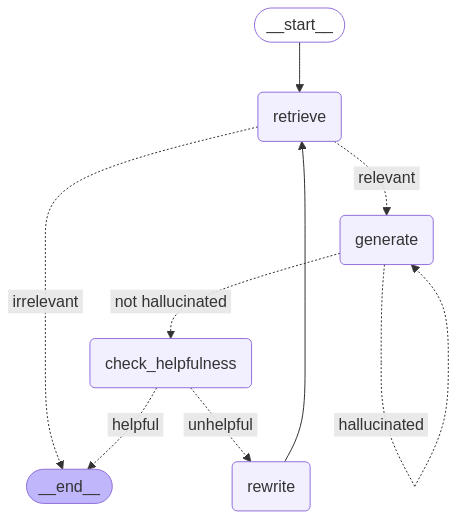

In [113]:
from IPython.display import Image, display

display(
    Image(
        graph.get_graph(xray=True).draw_mermaid_png()
    )
)


In [114]:
initial_state = {"query": "내 연봉은 얼마냐"}
graph.invoke(initial_state)

context == [Document(id='ebae0d79-e28d-49a9-86a2-5268132bf2a6', metadata={'source': './documents/income_tax.txt'}, page_content="바. '국공료보상 송환 및 모두에 관한 법령' 또는 '목록 프로포즈'가 받는 보수 및 퇴직소득\n사. '교육기본법', 제28조21항에 따라 받는 장학금 즉 대학교에서 근로를 제공받는 장학금('고등교육법', 제62조제1항에 따라 규정에 대하여 재학생 대학교에 설명한다)\n아. '마봉법' 제52조2에 따라 직무방법으로 비근로 보상의 수단(이 하 '직무보상금'이라 한다)으로서 대통령령으로 정하는 급여\n1) 대변법이 통금법에 따른 원칙으로 이 조, 제20조 및 제21조에서 ‘중복되는 것’이라 한다) 같은 의로부터 사용하는 것을 이하 이 조에서 ‘사용자’이라 한다. 따라서 보상금을 지급한 사용자들\n소득세법\n과 대통령령으로 정하는 특수관계에 있는 자가 받는 보상금은 제외한다.\n다만 대학교의 직원 또는 대학과 고용관계에 있는 자를 사업의 소속 대학의 ‘산학협력단’(이하 “산학협력단”이라 한다)이나 이 조에서 “산학협력단”이라 표현하는 제32조제1항 제4호에 따라 받는 보상금\n제1. 대통령령으로 정하는 복리후생적 성격의 급여\n6. 연금소득 중 다음 각 목의 이하여 하여야 하는 소득\n가. 구인연금법, 공무원연금법, 또는 공무원 재해보상법, 구인연금법, 사립학교교직원연금법, 법정정년퇴직급여법 또는 구인연금과 직역연금에 관한 법률(이하 “고정급금”이라 한다)에 따라 받는 유직연금·퇴직유직연금·퇴역예금·장해연금·상이어금·준약유직연금·직무상해적연금·위험직무수당연금, 장애연금·비공무사장해연금·비직무상해연금, 연계퇴직연금 또는 연계퇴직유직연금\n나. 사체 2013. 1. 1.\n다. 산업재해보상보험법에 따라 받는 자격 연금\n라. 국가프로포르 송환 및 대우 등에 관한 법률에 따른 국가프로포르가 받는 연금\n마. 사체 2013. 1. 1.\n7. 기

{'query': '내 연봉은 얼마냐',
 'context': [Document(id='ebae0d79-e28d-49a9-86a2-5268132bf2a6', metadata={'source': './documents/income_tax.txt'}, page_content="바. '국공료보상 송환 및 모두에 관한 법령' 또는 '목록 프로포즈'가 받는 보수 및 퇴직소득\n사. '교육기본법', 제28조21항에 따라 받는 장학금 즉 대학교에서 근로를 제공받는 장학금('고등교육법', 제62조제1항에 따라 규정에 대하여 재학생 대학교에 설명한다)\n아. '마봉법' 제52조2에 따라 직무방법으로 비근로 보상의 수단(이 하 '직무보상금'이라 한다)으로서 대통령령으로 정하는 급여\n1) 대변법이 통금법에 따른 원칙으로 이 조, 제20조 및 제21조에서 ‘중복되는 것’이라 한다) 같은 의로부터 사용하는 것을 이하 이 조에서 ‘사용자’이라 한다. 따라서 보상금을 지급한 사용자들\n소득세법\n과 대통령령으로 정하는 특수관계에 있는 자가 받는 보상금은 제외한다.\n다만 대학교의 직원 또는 대학과 고용관계에 있는 자를 사업의 소속 대학의 ‘산학협력단’(이하 “산학협력단”이라 한다)이나 이 조에서 “산학협력단”이라 표현하는 제32조제1항 제4호에 따라 받는 보상금\n제1. 대통령령으로 정하는 복리후생적 성격의 급여\n6. 연금소득 중 다음 각 목의 이하여 하여야 하는 소득\n가. 구인연금법, 공무원연금법, 또는 공무원 재해보상법, 구인연금법, 사립학교교직원연금법, 법정정년퇴직급여법 또는 구인연금과 직역연금에 관한 법률(이하 “고정급금”이라 한다)에 따라 받는 유직연금·퇴직유직연금·퇴역예금·장해연금·상이어금·준약유직연금·직무상해적연금·위험직무수당연금, 장애연금·비공무사장해연금·비직무상해연금, 연계퇴직연금 또는 연계퇴직유직연금\n나. 사체 2013. 1. 1.\n다. 산업재해보상보험법에 따라 받는 자격 연금\n라. 국가프로포르 송환 및 대우 등에 관한 법률에 따른 국가프로포르가 받는 연금\

In [115]:
initial_state = {"query": "연봉 3천만원 거주자 소득세 얼마인가요?"}
graph.invoke(initial_state)

context == [Document(id='cff0738b-e15c-47e3-9366-61e7083d9819', metadata={'source': './documents/income_tax.txt'}, page_content='제59조의3(연금계좌세액공제) ① 종합소득이 있는 거주자가 연금계좌에 납입한 금액 중 다음 각 호에 해당하는 금액을 제외한 금액(이하 "연금계좌 납입액"이라 한다) 중 100분의 12에 해당하는 과세기간에 종합소득세표준을 계산할 때 한산하는 종합소득금액이 4천500만원 이하(근로소득이 있는 경우에는 종합소득금액이 5천500만원 이하)에 대해서는 100분의 15에 해당하는 금액을 해당 과세기간의 종합소득세산출세액에서 공제한다. 다만, 연금계좌 중 연금주계좌에 납입한 금액이 연 600만원을 초과하는 경우에는 초과하는 금액은 그 금액으로 하고, 연금주계좌에 납입한 금액 중 600만원 이내의 금액과 기타연금계좌에 납입한 금액을 합한 금액이 연 900만원을 초과하는 경우에는 그 초과하는 금액은 금액으로 하는 것으 로 한다. <개정 2014. 12. 31.>\n1. 제146조제28항에 따른 소득세 원천징수대상이 아닌 퇴직소득 등 기타 예외 소득\n2. 연금계좌에 따른 연금계좌세액공제는 납입된 금액\n③ 제1항에 따른 공제는 "연금계좌세액공제"라 한다.\n④ "조세특례제한법", 제59조의18에 따른 기금이행자산관리계약이 만료되고 해당 계좌 잔여의 종류도 일정한 방법으로 정하는 방법으로 연금계좌에 납입한 금액(이하 이 조에서 "전환금"이라 한다)을 납입한 법인 또는 실속있는 방법으로 연금계좌의 납입액을 포함한다. <신설 2019. 12. 31.>\n⑤ 전환금이 있는 경우 제1항 각 호의 부분 구분에서 불가피한 경우 한정 적용 할 전환금의 100분의 10을 초과하는 경우 제2항 각 호에 기한 연금계좌 세액에 발생한 금액에 대하여 차감하는 금액을 총 중간계좌 세액이 제1항 각 호에 해당 연금계좌에 납입한 금액으로 하는 금액을 포함하는 금액은 금액으로 

{'query': '연봉 3천만원 거주자 소득세 얼마인가요?',
 'context': [Document(id='cff0738b-e15c-47e3-9366-61e7083d9819', metadata={'source': './documents/income_tax.txt'}, page_content='제59조의3(연금계좌세액공제) ① 종합소득이 있는 거주자가 연금계좌에 납입한 금액 중 다음 각 호에 해당하는 금액을 제외한 금액(이하 "연금계좌 납입액"이라 한다) 중 100분의 12에 해당하는 과세기간에 종합소득세표준을 계산할 때 한산하는 종합소득금액이 4천500만원 이하(근로소득이 있는 경우에는 종합소득금액이 5천500만원 이하)에 대해서는 100분의 15에 해당하는 금액을 해당 과세기간의 종합소득세산출세액에서 공제한다. 다만, 연금계좌 중 연금주계좌에 납입한 금액이 연 600만원을 초과하는 경우에는 초과하는 금액은 그 금액으로 하고, 연금주계좌에 납입한 금액 중 600만원 이내의 금액과 기타연금계좌에 납입한 금액을 합한 금액이 연 900만원을 초과하는 경우에는 그 초과하는 금액은 금액으로 하는 것으 로 한다. <개정 2014. 12. 31.>\n1. 제146조제28항에 따른 소득세 원천징수대상이 아닌 퇴직소득 등 기타 예외 소득\n2. 연금계좌에 따른 연금계좌세액공제는 납입된 금액\n③ 제1항에 따른 공제는 "연금계좌세액공제"라 한다.\n④ "조세특례제한법", 제59조의18에 따른 기금이행자산관리계약이 만료되고 해당 계좌 잔여의 종류도 일정한 방법으로 정하는 방법으로 연금계좌에 납입한 금액(이하 이 조에서 "전환금"이라 한다)을 납입한 법인 또는 실속있는 방법으로 연금계좌의 납입액을 포함한다. <신설 2019. 12. 31.>\n⑤ 전환금이 있는 경우 제1항 각 호의 부분 구분에서 불가피한 경우 한정 적용 할 전환금의 100분의 10을 초과하는 경우 제2항 각 호에 기한 연금계좌 세액에 발생한 금액에 대하여 차감하는 금액을 총 중간계좌 세액이 제1항 각 호에 해당